## Sanity Check Debevec

Check impact of leak on burner temperature (via comparison of methane results).

**TODO:**
- `[✓]` illustrate underlying HDR data
- `[✓]` show noise extraction
- `[✓]` show cube, scaling issue is fixed
- `[✓]` show raw data
- `[✓]` illustrate filament extraction
- `[✓]` show pyrometry

Access routines are in `database.py`; underlying hdr code is in `hdr.py`; base classes are defined in `base.py`; pyrometry code is in `pyrometry.py`, etc.

In [62]:
import numpy as np
import pandas as pd
import glob

import matplotlib.pylab as plt
%matplotlib inline

#import microfit.process as pr"
import microfit.hdr as hdr
import microfit.pyrometry as pyro
import microfit.microphone as mic
import microfit.chemiluminescence as cl
from microfit import filaments as fls
from microfit import fourier
from microfit import positioners as ptn
from microfit import database as db

from microfit import base
from importlib import reload

#import os

import warnings
warnings.filterwarnings(action='once')
#warnings.filterwarnings(action='error')

In [63]:
plt.style.use('manuscript.mplstyle')
plt.rcParams['figure.figsize']

[8.0, 5.5]

In [64]:
show = True

In [65]:
#%config InlineBackend.figure_formats = ['svg','retina'] # 
plt.rcParams['figure.figsize']

[8.0, 5.5]

In [67]:
xlsx = 'index_2018_02_PRF_data.xlsx'
df = pd.read_excel(xlsx)

### Select Data for Gaseous Fuels

In [68]:
cases = np.unique(df.case)
#print(cases)
#cases = [ c for c in cases if c.split('_')[-1]=='top']
cases = [ c for c in cases if c.split('_')[0]=='prf80'] #+ #[ c for c in cases if c.split('_')[0]=='methane']
print(cases)

['prf80_feb26_top']


In [69]:
ix = df.case.isin(cases)
dfsub = df[ix]

In [70]:
df.fuel.unique()

array(['ON80'], dtype=object)

In [71]:
rp = db.Database(dfsub,buffer_raw=True,verbosity=2) #,locate=False)

C:\Users\Navid\Anaconda3\lib\site-packages\microfit\database.py:108: RuntimeWarning: Detected unused columns (e.g. "raw1", "hdr1", "line1", etc.): DataBase objects no longer use columns to access various objects; instead, `ImageFrames` handle individual measurements. `ImageFrames` are accessed via columns "frame1" and "frame2" for cameras 1 and 2, respectively. Future versions of the  xlsx overview will not contain those columns.
  warnings.warn(msg, RuntimeWarning)
C:\Users\Navid\Anaconda3\lib\site-packages\microfit\database.py:126: RuntimeWarning: This DataBase does not contain "darkframe" and/or "flatframe" calibration images. While default HDR methods currently do not use those images, advanced HDR methods (e.g. Kirk) will not work. Additional warnings mentioning missing `DarkFrame` or `FlatFlame` objects will be triggered. To eliminate warnings, include "darkframe" and "flatframe" entries in the pandas DataFrame passed as argument.
  warnings.warn(msg, RuntimeWarning)


### Accessing raw/HDR data

In [74]:
# access routine (looks through data base ... pandas.DataFrame)
seq = rp.find_sequence_by('case',v=[20,30],d=76.2)
seq

{'prf80_feb26_top': [4, 5, 6]}

In [11]:
# row extracted from underlying data base ... pandas.Series
dp = rp.datapoint_by_locator(11)
dp

C:\Users\Navid\Anaconda3\lib\site-packages\microfit\database.py:1008: DeprecationWarning: ``datapoint_by_locator`` renamed to ``measurement``
  warnings.warn(msg, DeprecationWarning)


case                                            prf80_feb26_top
fuel                                                       ON80
d                                                          76.2
ve                                                          160
phie                                                       0.65
v                                                            80
phi                                                           1
testid                                                       11
n_hdrfiles                                                    8
tube_ID                                                       1
tube_OD                                                       3
offset                                                     25.4
desc           Prf80_d76.2_v80.0_phi1.00_p1.00_(ve160_phie0.65)
prefix        C:\Users\Navid\notebooks_master\fuels\prf80_fe...
mic                                                         NaN
cube                                    

In [14]:
rp.get_entry(11,'extl_val')

1615.847

In [16]:
raw1 = rp.load_raws(seq,camera=1)
raw1

Case: prf80_feb26_top (C:\Users\Navid\notebooks_master\fuels\prf80_feb26_top)
 * load_raw -> Prf80_d76.2_v80.0_phi1.00_p1.00_(ve160_phie0.65)
    <RawFrame.fetch_raw> ... retrieving buffered RAW image


{'prf80_feb26_top': <Imagestack object: 6x(1,15,256,1280,1) at 0x1d7df606a58>}

In [17]:
rr = [raw1[r] for r in raw1][0]
rr

<Imagestack object: 6x(1,15,256,1280,1) at 0x1d7df606a58>

In [18]:
[r for r in rr.channels]

['f435x40h', 'f650x50h', 'f750x50h', 'f850x50h', 'f950x50h', 'f1050x50h']

In [20]:
dp = rp.datapoint_by_locator(11)
dp

C:\Users\Navid\Anaconda3\lib\site-packages\microfit\database.py:1008: DeprecationWarning: ``datapoint_by_locator`` renamed to ``measurement``
  warnings.warn(msg, DeprecationWarning)


case                                            prf80_feb26_top
fuel                                                       ON80
d                                                          76.2
ve                                                          160
phie                                                       0.65
v                                                            80
phi                                                           1
testid                                                       11
n_hdrfiles                                                    8
tube_ID                                                       1
tube_OD                                                       3
offset                                                     25.4
desc           Prf80_d76.2_v80.0_phi1.00_p1.00_(ve160_phie0.65)
prefix        C:\Users\Navid\notebooks_master\fuels\prf80_fe...
mic                                                         NaN
cube                                    

In [21]:
hdr1 = rp.generate_hdrs(seq,camera=1)
hdr1

Case: prf80_feb26_top (C:\Users\Navid\notebooks_master\fuels\prf80_feb26_top)
 * generate_hdr -> Prf80_d76.2_v80.0_phi1.00_p1.00_(ve160_phie0.65)
    <RawFrame.fetch_raw> ... retrieving buffered RAW image
    <HDRFrame.fetch_hdr> ... generating HDR image (Debevec)


{'prf80_feb26_top': <Debevec object: 6x(256,1280) at 0x1d7df635b70>}

In [22]:
# get one of the HDR objects out of the dictionary for further analysis
h = [hdr1[c] for c in hdr1][0]
h

<Debevec object: 6x(256,1280) at 0x1d7df635b70>

In [23]:
# show sensor noise
h.source.sensor_noise()

C:\Users\Navid\Anaconda3\lib\site-packages\microfit\base.py:127: DeprecationWarning: References handled via the `source` attribute (formerly used to "daisy-chain" objects) are discontinued. Instead, a string containing the file name is returned: use `ImageFrame` objects to access objects/data as needed.
  warnings.warn(msg, DeprecationWarning)


AttributeError: 'str' object has no attribute 'sensor_noise'

In [24]:
# channels
h.channels

['f435x40h', 'f650x50h', 'f750x50h', 'f850x50h', 'f950x50h', 'f1050x50h']

In [25]:
# exposures
h.source.exposures

C:\Users\Navid\Anaconda3\lib\site-packages\microfit\base.py:127: DeprecationWarning: References handled via the `source` attribute (formerly used to "daisy-chain" objects) are discontinued. Instead, a string containing the file name is returned: use `ImageFrame` objects to access objects/data as needed.
  warnings.warn(msg, DeprecationWarning)


AttributeError: 'str' object has no attribute 'exposures'

In [26]:
# hdr objects still original raw data: grab a random raw channel
idx = 3
ch = [ c for c in h ][idx]
raw = h.source.data[ch]
ch,raw.shape

C:\Users\Navid\Anaconda3\lib\site-packages\microfit\base.py:127: DeprecationWarning: References handled via the `source` attribute (formerly used to "daisy-chain" objects) are discontinued. Instead, a string containing the file name is returned: use `ImageFrame` objects to access objects/data as needed.
  warnings.warn(msg, DeprecationWarning)


AttributeError: 'str' object has no attribute 'data'

In [27]:
#hdr,var = debevec_HDR(h.raw['f435x40h'],h.exposures)
# recreate hdr data from (note: name `hdr` is already used)
hdrx,varx,overexposed = hdr.debevec_HDR(h.source.data[ch],h.source.exposures)

C:\Users\Navid\Anaconda3\lib\site-packages\microfit\base.py:127: DeprecationWarning: References handled via the `source` attribute (formerly used to "daisy-chain" objects) are discontinued. Instead, a string containing the file name is returned: use `ImageFrame` objects to access objects/data as needed.
  warnings.warn(msg, DeprecationWarning)


AttributeError: 'str' object has no attribute 'data'

In [28]:
#%config InlineBackend.figure_formats = ['svg','retina'] # 

In [29]:
# recreated data
plt.imshow(np.log(hdrx),cmap='inferno')

NameError: name 'hdrx' is not defined

C:\Users\Navid\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


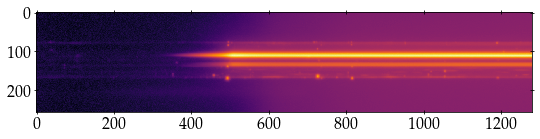

In [30]:
# original data
plt.imshow(np.log(h.data[ch]),cmap='inferno')

In [31]:
# estimate of variance (HDR is based on weighed log(images), i.e. `+`/`-` becomes `x`/`/`)
plt.imshow(np.log(hdrx*(varx-1)),cmap='inferno')

NameError: name 'hdrx' is not defined

In [32]:
[(hv.min(),hv.max(),) for hv in [hdrx,varx]]

NameError: name 'hdrx' is not defined

### Look at Sensor Noise

Use calibration image (*'cube'*) as filament is visible in measurement data even at short exposures.

In [33]:
# data with lowest velocity (integer values are labels of a pandas DataFrame that acts as a data base)
seq = rp.find_sequence_by('case',fuel='C3H8',v=5,d=76.2)
seq

IndexError: list index out of range

In [34]:
# calibration images corresponding to seq
cubes = rp.find_cubes(seq)
cubes

{'prf80_feb26_top': 0}

In [31]:
# load hdr data
hdr1 = rp.generate_hdrs(cubes,camera=1)

Case: propane_nov16_top (/work/Dropbox/Microfit_Data/2017_11_PROCI/fuels_Propane_nov16)
 * generate_hdr -> cube0
Case: propane_nov20_center (/work/Dropbox/Microfit_Data/2017_11_PROCI/fuels_Propane_nov20_center)
 * generate_hdr -> cube0


In [32]:
hdr1

{'propane_nov16_top': <HDR object: 6x(256,1280) at 0x7fa07f6c3208>,
 'propane_nov20_center': <HDR object: 6x(256,1280) at 0x7fa07f6c7198>}

#### Show raw images for shortest exposure

All images are vertically stacked.

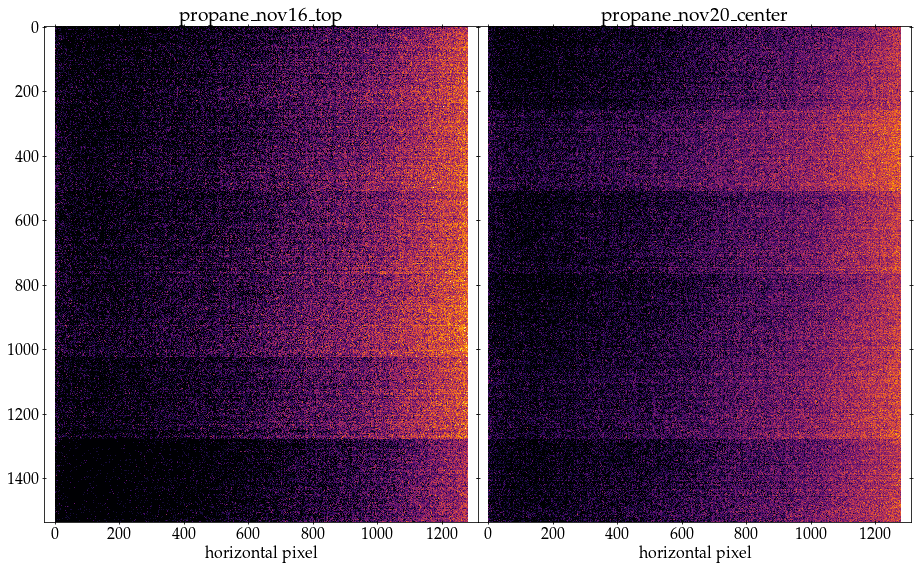

In [33]:
if show:
    fig,ax = plt.subplots(1,len(seq),sharey=True)
    fig.set_size_inches(14,8)
    for i,c,axx in zip(range(len(cases)),hdr1.keys(),ax):
    
        val = np.vstack([ hdr1[c].source.data[ch][0,0,...,0] for ch in hdr1[c] ])
        axx.imshow(val)
        axx.set_xlabel('horizontal pixel')
        axx.set_title('%s' % c.replace('_',r'\_'))

#### Obtain noise by directly accessing raw data

propane_nov16_top
(1, 15, 256, 1280, 1) (256, 1280)
(1, 15, 256, 1280, 1) (256, 1280)
(1, 15, 256, 1280, 1) (256, 1280)
(1, 15, 256, 1280, 1) (256, 1280)
(1, 15, 256, 1280, 1) (256, 1280)
(1, 15, 256, 1280, 1) (256, 1280)
propane_nov20_center
(1, 15, 256, 1280, 1) (256, 1280)
(1, 15, 256, 1280, 1) (256, 1280)
(1, 15, 256, 1280, 1) (256, 1280)
(1, 15, 256, 1280, 1) (256, 1280)
(1, 15, 256, 1280, 1) (256, 1280)
(1, 15, 256, 1280, 1) (256, 1280)


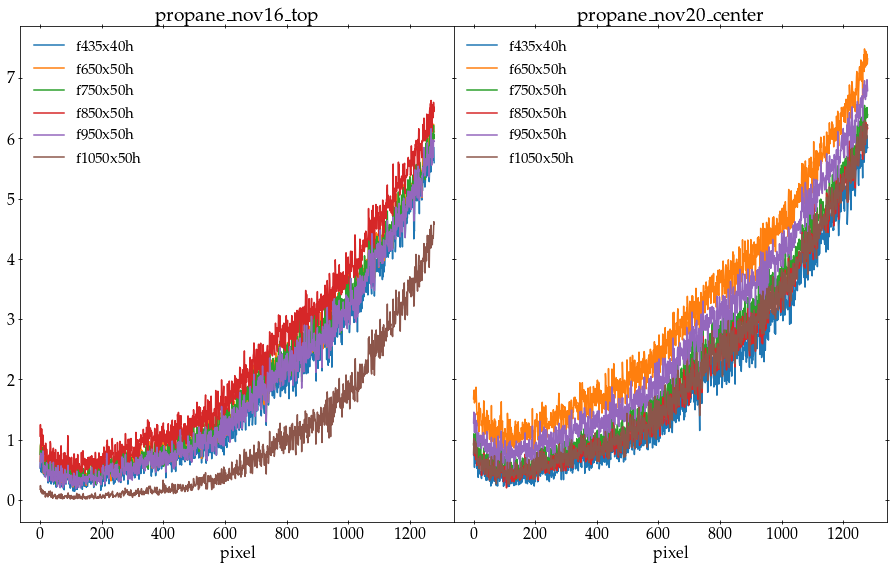

In [34]:
if show:
    fig,ax = plt.subplots(1,len(seq),sharey=True)
    fig.set_size_inches(14,8)
    for i,c,axx in zip(range(len(cases)),hdr1.keys(),ax):
    
        print(c)
        val = np.vstack([ hdr1[c].source.data[ch][0,0,...,0] for ch in hdr1[c] ])
    
        for ch in hdr1[c]:
            noise = hdr1[c].source.data[ch][0,0,...,0] # shortest exposure
            print(hdr1[c].source.data[ch].shape,noise.shape)
            axx.plot(noise.mean(axis=0),label=ch)
        axx.set_xlabel('pixel')
        axx.legend(loc='upper left')
        axx.set_title(r'%s' % c.replace('_',r'\_'))

#### Using `sensor_noise()` routine

Default behavior is to return average over rows. Takes arguments (e.g. denoising) ...

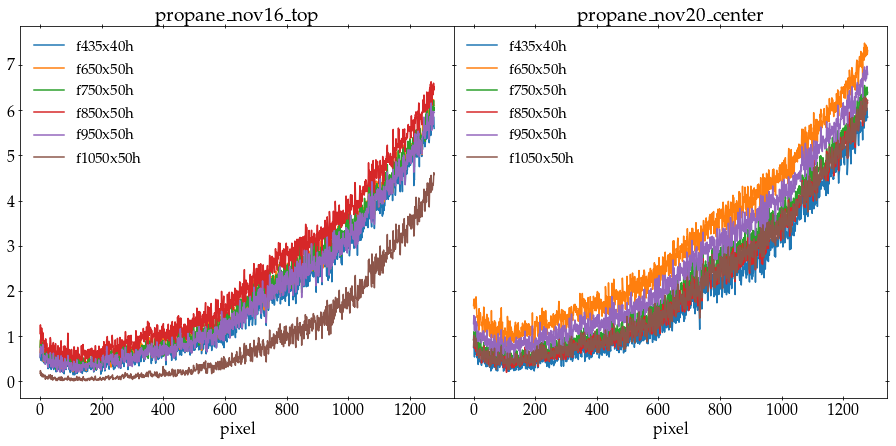

In [35]:
if show:
    fig,ax = plt.subplots(1,len(seq),sharey=True)
    fig.set_size_inches(14,6)
    #fig.subplots_adjust(hspace=0,wspace=0)
    #for a in ax.ravel():
    #    a.tick_params(which='both',direction='in',top=True,right=True)
    for i,c,axx in zip(range(len(cases)),hdr1.keys(),ax):
    
        noise = hdr1[c].source.sensor_noise(denoise='Median5') # average over rows / slightly filtered
        for ch in hdr1[c]:
            axx.plot(noise[ch],label=ch)
        axx.set_xlabel('pixel')
        axx.legend(loc='upper left')
        axx.set_title(r'%s' % c.replace('_',r'\_'))

### Calibration Cube

In [35]:
cubes = rp.find_cubes(seq)
cubes

{'prf80_feb26_top': 0}

In [36]:
hdr1 = rp.generate_hdrs(cubes,camera=1)
hdr1

Case: prf80_feb26_top (C:\Users\Navid\notebooks_master\fuels\prf80_feb26_top)
 * generate_hdr -> cube0
    <RawFrame.fetch_raw> ... loading RAW image: cube0_raw1.tif


C:\Users\Navid\Anaconda3\lib\site-packages\microfit\imageframes.py:72: RuntimeWarning: cannot locate `DarkFrame` calibration
  warnings.warn(msg, RuntimeWarning)
C:\Users\Navid\Anaconda3\lib\site-packages\microfit\imageframes.py:99: RuntimeWarning: cannot locate `FlatFrame` calibration
  warnings.warn(msg, RuntimeWarning)


    <HDRFrame.fetch_hdr> ... generating HDR image (Debevec)


{'prf80_feb26_top': <Debevec object: 6x(256,1280) at 0x1d7e83f66a0>}

TypeError: zip argument #3 must support iteration

C:\Users\Navid\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


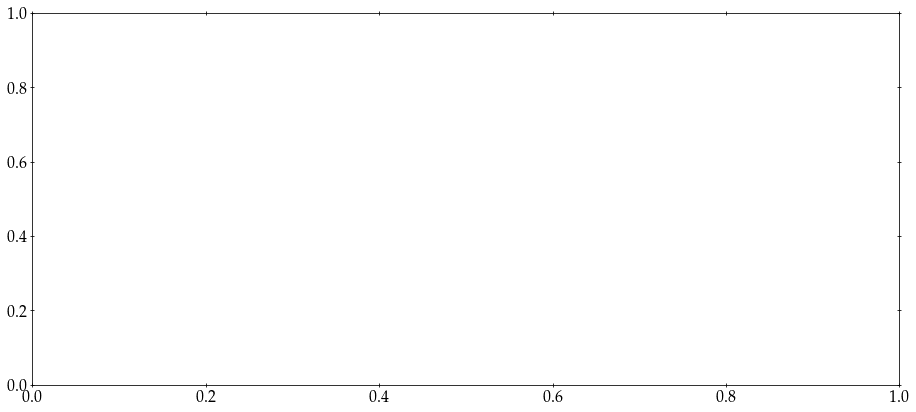

In [37]:
if show:
    fig,ax = plt.subplots(1,len(cubes),sharey=True)
    fig.set_size_inches(14,6)
    #fig.subplots_adjust(hspace=0,wspace=0)
    #for a in ax.ravel():
    #    a.tick_params(which='both',direction='in',top=True,right=True)

    for i,c,axx in zip(range(len(cases)),cubes.keys(),ax):
    
        #bkg = m.scale[c].sensor_noise()
        bkg = hdr1[c].background()
        xrng = hdr1[c].pos.x
        for ch in hdr1[c]:
            axx.plot(xrng,bkg[ch],label=ch)

    vert = ax[0].get_ylim()
    for c,axx in zip(cubes.keys(),ax):
    
        xl,xr = hdr1[c].pos.xref
    
        axx.plot([xl,xl],vert,'k:')
        axx.plot([xr,xr],vert,'k:')
        axx.plot([0,0],vert,'k:')

        axx.set_ylim(vert)
        axx.set_xlabel(r'axial position -- x (mm)')
        axx.set_title(c.replace('_',r'\_'))

### Show HDR Data (regular/log-scale)

In [41]:
# select some data
seq = rp.find_sequence_by('phi',v=30,d=76.2)
seq

{'nan': -1, '1': 6}

In [42]:
hdr1 = rp.generate_hdrs(seq,camera=1)
hdr1

KeyError: 'the label [-1] is not in the [index]'

In [43]:
n_channel = [ len(hdr1[h].channels) for h in hdr1 ][0]
channels = [ hdr1[h].channels for h in hdr1 ][0]
n_channel, channels

AttributeError: 'list' object has no attribute 'channels'

In [44]:
#hdr1[c].shape

In [45]:
if show:
    
    fig,ax = plt.subplots(n_channel,len(seq))
    fig.subplots_adjust(hspace=.025,wspace=.05)
    fig.set_size_inches(17,7.5)
    xs = np.array([0,1280])
    
    for a in ax.ravel():
        a.xaxis.set_ticklabels([])
        a.yaxis.set_ticklabels([])

    for ch,i in zip(channels,range(n_channel)):
    
        for c,j in zip(hdr1.keys(),range(len(hdr1))):
            ax[i,j].imshow(hdr1[c][ch],cmap='inferno',aspect='auto')
            ys = hdr1[c].pos.tube_outline(xs)
            for pos in ['ODt','ODb']:
                ax[i,j].plot(xs,ys[pos],'r-',linewidth=2)
            for pos in ['IDt','IDb']:
                ax[i,j].plot(xs,ys[pos],'r:',linewidth=1)
            ax[i,j].set_xlim(xs)
        ax[i,0].set_ylabel(ch) #.split('x')[0][1:]+'nm')
    
    for c,j in zip(hdr1.keys(),range(len(hdr1))):
        ax[0,j].set_title(r'radiosity: %s' % c.replace('_',r'\_'))

NameError: name 'n_channel' is not defined

In [46]:
if show:
    
    fig,ax = plt.subplots(n_channel,len(seq))
    fig.subplots_adjust(hspace=.025,wspace=.05)
    fig.set_size_inches(17,7.5)
    
    for a in ax.ravel():
        a.xaxis.set_ticklabels([])
        a.yaxis.set_ticklabels([])

    for ch,i in zip(channels,range(n_channel)):
    
        for c,j in zip(hdr1.keys(),range(len(hdr1))):
            ax[i,j].imshow(np.log(hdr1[c].data[ch]),cmap='inferno')
        ax[i,0].set_ylabel(ch) #.split('x')[0][1:]+'nm')
    
    for c,j in zip(hdr1.keys(),range(len(hdr1))):
        ax[0,j].set_title(r'log(radiosity): %s' % c.replace('_',r'\_'))


NameError: name 'n_channel' is not defined

### Extract Filament

In [49]:
# select some data
seq = rp.find_sequence_by('case',v=50,d=76.2)
seq

{'prf80_feb26_top': 8}

In [51]:
dp = rp.datapoint_by_locator(11)
dp.raw1

C:\Users\Navid\Anaconda3\lib\site-packages\microfit\database.py:1008: DeprecationWarning: ``datapoint_by_locator`` renamed to ``measurement``
  warnings.warn(msg, DeprecationWarning)


AttributeError: 'Series' object has no attribute 'raw1'

In [52]:
# extract filaments
lines = rp.extract_filaments(seq,camera=1,force=True) #,filament_type='Gaussian')
lines

Case: prf80_feb26_top (C:\Users\Navid\notebooks_master\fuels\prf80_feb26_top)
 * extract_filament -> Prf80_d76.2_v50.0_phi1.00_p1.00_(ve160_phie0.65)
    <RawFrame.fetch_raw> ... loading RAW image: Prf80_d76.2_v50.0_phi1.00_p1.00_(ve160_phie0.65)_raw1.tif


C:\Users\Navid\Anaconda3\lib\site-packages\microfit\imageframes.py:72: RuntimeWarning: cannot locate `DarkFrame` calibration
  warnings.warn(msg, RuntimeWarning)
C:\Users\Navid\Anaconda3\lib\site-packages\microfit\imageframes.py:99: RuntimeWarning: cannot locate `FlatFrame` calibration
  warnings.warn(msg, RuntimeWarning)
C:\Users\Navid\Anaconda3\lib\site-packages\microfit\database.py:504: DeprecationWarning: keyword `force` no longer supported: need for recalculation due to parameter changes is now detected automatically
  warnings.warn(msg, DeprecationWarning)


    <HDRFrame.fetch_hdr> ... generating measurement image (Debevec)


AttributeError: 'NoneType' object has no attribute 'pos'

In [48]:
lines['propane_nov16_top'].meta

{'analysis.class': 'Fourier',
 'analysis.kernel_width': array([ 0.18167828,  0.52682232,  0.46121894,  0.35276246,  0.26094278,
         0.20464503]),
 'analysis.margin': 0.2,
 'analysis.mask_threshold': 0.25,
 'analysis.noise_cutoff': 0.5,
 'analysis.resolved_filament': True,
 'analysis.scale_filament': 2.9040000000000004,
 'analysis.scale_filament_apparent': 2.6391752577319587,
 'analysis.scale_reject': 57.165354330708666,
 'analysis.size_filament_micron': 76.200000000000003,
 'analysis.size_reject_mm': 1.5,
 'hdr.algorithm': 'debevec',
 'hdr.denoise': None,
 'hdr.sensor_noise': False,
 'hdr.shape': (256, 1280),
 'line.algorithm': 'Fourier',
 'line.includes_filterdata': False,
 'line.includes_sensordata': False,
 'line.normalized': True,
 'line.snr_cutoff': 2.0,
 'raw.fname': '/work/Dropbox/Microfit_Data/2017_11_PROCI/fuels_Propane_nov16/Propane_d76.2_v50.0_phi1.0_(ve160_phie0.55)_raw1.tif',
 'source.fname': '/work/Dropbox/Microfit_Data/2017_11_PROCI/fuels_Propane_nov16/Propane_d76.2

### Illustrate results (along line)

In [49]:
# get one of the lines
line = [lines[c] for c in lines][0]
line.n_channels,line

(6, <Filament object: 6x(1280) at 0x7fa0538a45c0>)

In [50]:
line.shape

(1280,)

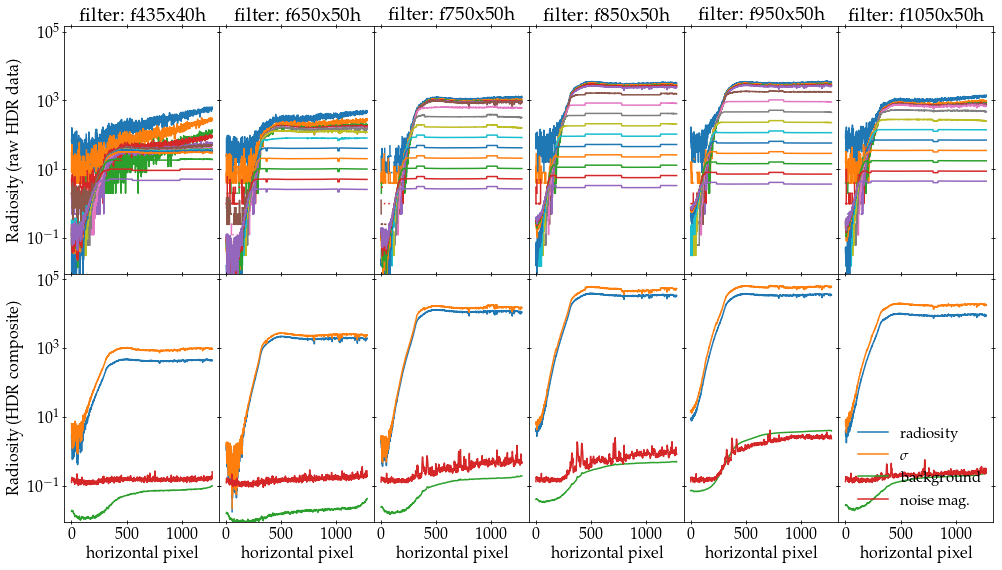

In [51]:
if show:

    fig,ax = plt.subplots(2,line.n_channels,sharex=True,sharey=True)
    fig.set_size_inches(15,8)

    #fig.subplots_adjust(hspace=0,wspace=0)
    #for a in ax.ravel():
    #    a.tick_params(which='both',direction='in',top=True,right=True)

    ymin = 1
    ymax = 1

    for i,f in zip(range(line.n_channels),line.channels):
    
        if f in line.channels:
            ax[1,i].semilogy(line.data[f],label='radiosity')
            ax[1,i].semilogy(line.data[f]*(line.var[f]**.5-1),label=r'$\sigma$')
            ax[1,i].semilogy(line.bkg[f],label=r'background')
            ax[1,i].semilogy(line.noise[f],label=r'noise mag.')

            ymin = min(line.data[f].min(),ymin)
            ymax = max(line.data[f].max(),ymax)
    
            source = line.seek(base.Imagestack)
            exp = source.exposures
            ax[0,i].semilogy(line.raw[f] / (np.ones((line.shape[0],1,))*np.array(exp)))
            ymin = min(line.raw[f].min(),ymin)
            ymax = max(line.raw[f].max(),ymax)
        
        ax[0,i].set_title('filter: %s' % f)
        ax[1,i].set_xlabel('horizontal pixel')
    
    leg = ax[1,-1].legend(loc='lower right')
    leg.draw_frame(False)

    #ax[0,0].set_ylim([.5*ymin,2.*ymax]) #ax[0,0].get_ylim()[1]])
    ax[0,0].set_ylabel('Radiosity (raw HDR data)')
    ax[1,0].set_ylabel('Radiosity (HDR composite)')

In [52]:
#fig.savefig('HDR_illustration.pdf')
#fig.savefig('HDR_illustration.svg')

### Compare results

In [53]:
v = 80
ve = 160

In [54]:
# select some data
seq = rp.find_sequence_by('case',fuel='CH4',v=v,d=76.2)
seq

{'methane_nov09_top': [4, 8, 12],
 'methane_nov10_top': [15, 18, 22, 26, 30, 34, 38, 42],
 'methane_nov15_top': 61,
 'methane_nov20_center': 80}

In [55]:
dp = rp.datapoint_by_locator(3)
dp

/work/Code/python/site-packages/microfit/database.py:443: DeprecationWarning: ``datapoint_by_locator`` renamed to ``measurement``
  warnings.warn(msg, DeprecationWarning)


case                                          methane_nov09_top
fuel                                                        CH4
d                                                          76.2
ve                                                          160
phie                                                        0.6
v                                                            50
phi                                                           1
testid                                                        4
n_hdrfiles                                                    8
tube_ID                                                       1
tube_OD                                                       3
offset                                                     25.4
desc               Methane_d76.2_v50.0_phi1.00_(ve160_phie0.60)
prefix        /work/Dropbox/Microfit_Data/2017_11_PROCI/burn...
mic           /work/Dropbox/Microfit_Data/2017_11_PROCI/burn...
cube                                    

In [56]:
isinstance(dp.raw1,str)

True

In [57]:
rp.get_entries(seq,'ve')

{'methane_nov09_top': [160.0, 160.0, 160.0],
 'methane_nov10_top': [120.0, 140.0, 140.0, 150.0, 160.0, 160.0, 160.0, 160.0],
 'methane_nov15_top': 160.0,
 'methane_nov20_center': 160.0}

In [58]:
seq = rp.find_sequence_by('case',fuel='CH4',v=v,d=76.2,ve=ve)
seq

{'methane_nov09_top': [4, 8, 12],
 'methane_nov10_top': [30, 34, 38, 42],
 'methane_nov15_top': 61,
 'methane_nov20_center': 80}

In [59]:
rp.get_entries(seq,'ve')

{'methane_nov09_top': [160.0, 160.0, 160.0],
 'methane_nov10_top': [160.0, 160.0, 160.0, 160.0],
 'methane_nov15_top': 160.0,
 'methane_nov20_center': 160.0}

In [57]:
seq = rp.find_sequence_by('phie',fuel='ON80',v=80,d=76.2)
seq

{'0.65': 11}

In [61]:
hdr1 = rp.extract_filaments(seq,force=True) #,filament_type='Gaussian') #fls.filament_fourier)
hdr1

Case: 0.55 (/work/Dropbox/Microfit_Data/2017_11_PROCI/burner_tests_nov10)
 * extract_filament -> Methane_d76.2_v80.0_phi1.0_(ve160_phie0.55)
    <load_raw> ... generate HDR calibration image: cube0_raw1.tif
    <load_raw> ... generate HDR image: Methane_d76.2_v80.0_phi1.0_(ve160_phie0.55)_raw1.tif
    <perform_analysis> ... creating new `Fourier` object
    <extract_filament> ... extracting `Fourier` filament
Case: 0.6 (/work/Dropbox/Microfit_Data/2017_11_PROCI/burner_tests_nov10)
 * extract_filament -> Methane_d76.2_v80.0_phi1.0_(ve160_phie0.60)
    <load_raw> ... generate HDR image: Methane_d76.2_v80.0_phi1.0_(ve160_phie0.60)_raw1.tif
    <perform_analysis> ... creating new `Fourier` object
    <extract_filament> ... extracting `Fourier` filament
Case: 0.625 (/work/Dropbox/Microfit_Data/2017_11_PROCI/burner_tests_nov10)
 * extract_filament -> Methane_d76.2_v80.0_phi1.0_(ve160_phie0.625)
    <load_raw> ... generate HDR image: Methane_d76.2_v80.0_phi1.0_(ve160_phie0.625)_raw1.tif
    <

{'0.55': <Filament object: 6x(1280) at 0x7fa053cc3ba8>,
 '0.6': <Filament object: 6x(1280) at 0x7fa053c9ac88>,
 '0.625': <Filament object: 6x(1280) at 0x7fa053c43d68>,
 '0.65': <Filament object: 6x(1280) at 0x7fa053adc8d0>}

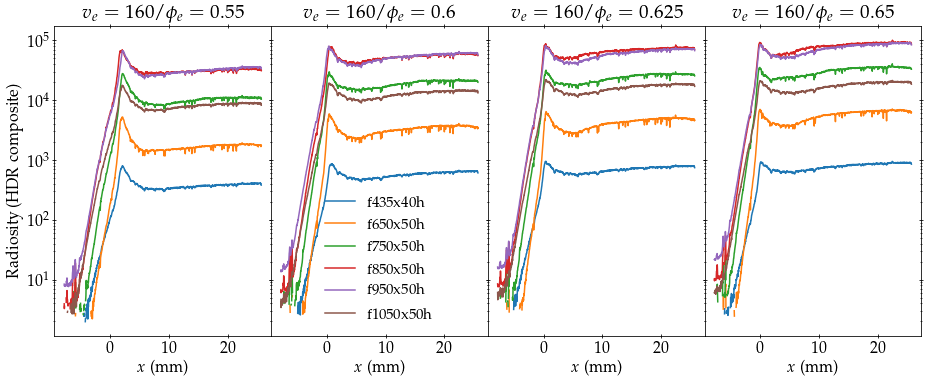

In [62]:
if True:

    fig,ax = plt.subplots(1,len(hdr1),sharex=True,sharey=True)
    fig.set_size_inches(14,5)

    #V0 = len(vels0)
    ymin = 1
    ymax = 1
    for c,i in zip(hdr1,range(len(hdr1))):
    
        #ax[i].set_title(c)
        py = hdr1[c]

        for f in py.channels:
            #h = ax[i].semilogy(py.x,py.hdr[f],':')
            #vld[vld<1] = np.nan
            h = ax[i].semilogy(py.pos.x,py[f],label=f) #,color=h[0].get_color())
        ymin = min(ymin,.5*py.min())
        ymax = max(ymax,2.*py.max())
                
    vert = [ymin,ymax]
    leg = ax[1].legend(loc='lower center')
    leg.draw_frame(False)

    for c,i in zip(hdr1,range(len(hdr1))):

        py = hdr1[c]
    
        #for v,j in zip(vels0,range(V0)):

        xl,xr = py.pos.xref
    
        #ax[i].plot([xl,xl],vert,'k--')
        #ax[i].plot([xr,xr],vert,'k--')
        #ax[i].plot([xr-2,xr-2],vert,'k:')
        #ax[i].plot([xr+2,xr+2],vert,'k:')
        #ax[i].plot([0,0],vert,'k-')

        #ax[i].set_ylim(vert)
        
        ax[i].set_title(r'$v_e=%1.0f / \phi_e=%s$' % (ve,c))
        ax[i].set_xlabel(r'$x$ (mm)')
    
    ax[0].set_ylabel('Radiosity (HDR composite)')     

In [63]:
#fig.savefig('radiosity.svg')

## Pyrometry

Note: previous version likely included a case with external velocity less than v150

In [53]:
v = 80
ve = 160
seq = rp.find_sequence_by('phie',v=40,d=76.2,ve=160)#case='methane_nov10_top')
seq

{'0.65': 11}

In [75]:
#seq['0.55'] = seq['0.55'][0]
#seq

In [78]:
rp.datapoint_by_locator(1).line1

C:\Users\Navid\Anaconda3\lib\site-packages\microfit\database.py:1008: DeprecationWarning: ``datapoint_by_locator`` renamed to ``measurement``
  warnings.warn(msg, DeprecationWarning)


AttributeError: 'Series' object has no attribute 'line1'

In [79]:
pyx,prx = rp.extract_temperatures(seq,blocked=['f435x40h'],force=True,snr=30) #,filament_type='Gaussian',snr=5.) # 
pyx

Case: prf80_feb26_top (C:\Users\Navid\notebooks_master\fuels\prf80_feb26_top)
 * extract_temperature -> Prf80_d76.2_v20.0_phi1.00_p1.00_(ve160_phie0.65)
    <PyroFrame> ... switching blocked channels
    <RawFrame.fetch_raw> ... loading RAW image: cube0_raw1.tif


C:\Users\Navid\Anaconda3\lib\site-packages\microfit\imageframes.py:72: RuntimeWarning: cannot locate `DarkFrame` calibration
  warnings.warn(msg, RuntimeWarning)
C:\Users\Navid\Anaconda3\lib\site-packages\microfit\imageframes.py:99: RuntimeWarning: cannot locate `FlatFrame` calibration
  warnings.warn(msg, RuntimeWarning)
C:\Users\Navid\Anaconda3\lib\site-packages\microfit\database.py:504: DeprecationWarning: keyword `force` no longer supported: need for recalculation due to parameter changes is now detected automatically
  warnings.warn(msg, DeprecationWarning)


    <HDRFrame.fetch_hdr> ... generating calibration image (Debevec)
    <CubeFrame.fetch_cube> ... characterizing reference cube
    <RawFrame.fetch_raw> ... loading RAW image: Prf80_d76.2_v20.0_phi1.00_p1.00_(ve160_phie0.65)_raw1.tif
    <HDRFrame.fetch_hdr> ... generating pyrometry image (Debevec)
    <MeasurementFrame.fetch_measurement> ... analyzing pyrometry (Fourier)


C:\Users\Navid\Anaconda3\lib\site-packages\microfit\analysis.py:179: RuntimeWarning: divide by zero encountered in double_scalars
  for pk, mu, sig in pms])
C:\Users\Navid\Anaconda3\lib\site-packages\microfit\analysis.py:569: RuntimeWarning: Mean of empty slice.
  deltaf[ch] = delta.mean(axis=0)
C:\Users\Navid\Anaconda3\lib\site-packages\numpy\core\_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


ValueError: Internal work array size computation failed: -5

In [68]:
#%config InlineBackend.figure_formats = ["retina"]

In [80]:
fig,ax = plt.subplots(1,len(pyx),sharex=True,sharey=True)
fig.set_size_inches(14,5)
#fig.subplots_adjust(hspace=0,wspace=0)
#for a in ax.ravel():
#    a.tick_params(which='both',direction='in',top=True,right=True)

ymin = 1200
ymax = 1200
temp = []

for c,i in zip(pyx,range(len(pyx))):

    py = pyx[c] #line[c][v]
    xrng = py.pos.x
    #tmod0,_,_,_ = pyro.calc_temperature_lsq(py.hdr,py.bkg,py.fmid,py.fwhm)
    #tmod1,_,_,_ = pyro.calc_temperature_lsq(py.hdr,py.bkg,py.fmid,py.fwhm,T0=tmod0)
    #tmod2,calib2,_,_ = pyro.calc_temperature_lsq(py.hdr,py.bkg,py.fmid,py.fwhm,T0=tmod1)
    tmod0 = py.data['temp_0']
    tmod1 = py.data['temp_1']
    tmod2 = py.data['temp_2']
    
    ax[i].plot(py.pos.x,tmod0,label='model=0',linestyle='--')
    ax[i].plot(py.pos.x,tmod1,label='model=1')
    ax[i].plot(py.pos.x,tmod2,label='model=2')
    
    ylim = ax[i].get_ylim()
    ymin = min(ymin,ylim[0])
    ymax = max(ymax,ylim[1])
    
    #edge = 0
    
    #slc1 = slice(py.ixr-50,py.ixr+50)
    #slc2 = slice(edge-2,edge+3)
    temp += [(py.measure(0,plus=0,minus=2),py.measure(25,plus=0,minus=2))]
    
vert = [ymin,ymax]
leg = ax[-1].legend(loc='lower center')
leg.draw_frame(False)
                
for c,i in zip(pyx,range(len(pyx))):

    py = pyx[c] #line[c][v]
    xl,xr = 0,25
    ax[i].plot([xr,xr],vert,'k:')
    ax[i].plot([0,0],vert,'k:')
    ax[i].set_ylim(vert)
    
    
        
    ax[i].set_title(r'$v_e=%1.0f / \phi_e=%s$' % (ve,c))
    ax[i].set_xlabel('$x$ (mm)')
    
ax[0].set_xlim([-15,35])
ax[0].set_ylabel(r'$T_\mathrm{pyro}$ (K)')        
temp = np.vstack(temp)

NameError: name 'pyx' is not defined

In [81]:
temp    

NameError: name 'temp' is not defined

```
If calculated with gaussian_filament and denoising ('Gaussian5'), results are:

array([[ {'temp_0': 1133.5514473170545, 'temp_1': 1067.383310915493, 'temp_2': 994.22744227068631},
        {'temp_0': 1396.0944881370292, 'temp_1': 1301.6889827896316, 'temp_2': 1195.6266802669586}],
       [ {'temp_0': 1269.2019341107086, 'temp_1': 1188.6824809247969, 'temp_2': 1098.9030647173579},
        {'temp_0': 1474.8068619503467, 'temp_1': 1371.2140653593206, 'temp_2': 1254.2934555158711}],
       [ {'temp_0': 1275.7406380370639, 'temp_1': 1194.4725732524983, 'temp_2': 1103.8292483007251},
        {'temp_0': 1505.7084395448207, 'temp_1': 1398.438794668589, 'temp_2': 1277.1435121568206}],
       [ {'temp_0': 1348.2965441379602, 'temp_1': 1258.8894126636212, 'temp_2': 1158.6949533545057},
        {'temp_0': 1535.348446462591, 'temp_1': 1424.5133509436437, 'temp_2': 1298.9623238012459}]], dtype=object)
```

In [71]:
#fig.savefig('methane_sanity_%s.png' % vv)

In [72]:
#
#fig.savefig('preliminary_profile.svg')

### Check System Response Function

MATLAB function from Devebec and Malik, **Recovering High Dynamic Range Radiance Maps from Photographs**, SIGGRAPH 97

Important: do not do this for averages (only works for actual pixel values)

```python
# hello world
print('ha')
```

Below is not updated!!

In [73]:
# gg = dict.fromkeys(fw)

# for i,f in zip(range(F),fw):
#     Z = line[c][v].raw[f]
#     B = np.log(np.vstack([e*np.ones((Z.shape[0],)) for e in exp])).T
#     g0,lE0 = wf.gsolve(Z,B,l=3,wfun=wf.weight_triangle)
#     gg[f] = np.nan*np.zeros((2**10))
#     gg[f][:g0.shape[0]] = g0

In [74]:
# fig,ax = plt.subplots(2,2)

# fig.set_size_inches((10,10))
# ax[0,0].set_ylabel('Z -- pixel value')
# ax[1,0].set_ylabel('log(Z)')
# ax[1,0].set_xlabel(r'logarithmic exposure -- $\log(E_i \Delta t)$')
# ax[1,1].set_xlabel(r'exposure -- $E_i \Delta t$')
# fig.subplots_adjust(hspace=0,wspace=0)
# for a in ax.ravel():
#     a.tick_params(direction='in',top=True,right=True)

# for f in fw:
    
#     g0 = gg[f]
#     n = g0.shape[0]
#     x = np.arange(n)
    
#     ax[0,0].plot(g0,x)
#     ax[1,0].plot(g0[1:],np.log(x[1:]))
#     ax[0,1].plot(np.exp(g0),x,label=f)
#     ax[1,1].plot(np.exp(g0[1:]),np.log(x[1:]))
    
#     idx = np.vstack([(np.log(x[1:])>3),np.isfinite(g0[1:])])
#     idx = idx.all(axis=0)
    
    
# ax[0,1].legend(loc='lower right')

In [75]:
# absc = np.vstack([lE0+B[:,i] for i in range(B.shape[1])]).T

# fig,ax = plt.subplots(1,1)
# fig.set_size_inches((14,10))

# idx = np.ones((B.shape[1],),dtype=bool)
# idx[6:8] = False
# ax.plot(absc,Z,'.')
# ax.set_ylabel('Z -- pixel value')
# ax.set_xlabel(r'logarithmic exposure -- $\log(E_i \Delta t)$')

# absc.shape

In [76]:
# absc.shape